In [ ]:
# Ensure Theano uses the GPU
import os
os.environ["THEANO_FLAGS"] = "device=cuda,floatX=float32"

%pip install requests pandas census

In [ ]:
%pip install pandas cenpy

import cenpy as c
import pandas as pd

# Define the list of variables to extract from ACS
variables = {
    'median_home_value': 'B25077_001E',
    'bachelors_degree_or_higher': 'B15003_022E',
    'commute_public_transit': 'B08301_010E',
    'commute_bicycle': 'B08301_019E',
    'commute_walking': 'B08301_018E',
    'average_travel_time': 'B08303_001E',
    'total_white': 'B02001_002E',
    'total_black': 'B02001_003E',
    'total_asian': 'B02001_005E',
    'total_hispanic': 'B03002_012E',
    'median_household_income': 'B19013_001E',   # Median Household Income
    'gini_index': 'B19083_001E',                 # Gini Index (Income Inequality)
    'unemployment': 'B23025_005E',               # Unemployment Count
    'labor_force': 'B23025_003E',                # Labor Force Total Count
    'poverty_count': 'B17001_002E',              # Poverty Count
    'total_population': 'B01003_001E'            # Total Population
}

# Define the years for ACS 5-year estimates (2017-2022)
years = ['ACSDT5Y2017', 'ACSDT5Y2018', 'ACSDT5Y2019', 'ACSDT5Y2020', 'ACSDT5Y2021', 'ACSDT5Y2022']

# FIPS code for San Francisco County, California
geo_filter = {'state': '06', 'county': '075'}

# Create an empty DataFrame to append data from multiple years
acs_data_frames = []

# Loop through each year and download the data
for year in years:
    connection = c.remote.APIConnection(year)

    # Extract the data for San Francisco tracts with the specified variables
    try:
        data = connection.query(cols=list(variables.values()), geo_unit='tract', geo_filter=geo_filter)
        data['year'] = year[-4:]  # Add a column for the year

        # Rename the columns with descriptive variable names
        data = data.rename(columns={v: k for k, v in variables.items()})

        # Append the data to the list of DataFrames
        acs_data_frames.append(data)

        print(f"Successfully retrieved data for year {year[-4:]}")

    except Exception as e:
        print(f"Failed to retrieve data for year {year[-4:]}. Error: {e}")

# Combine all the years into one DataFrame
acs_data = pd.concat(acs_data_frames, ignore_index=True)

# Save the data to a CSV file
acs_data.to_csv('San_Francisco_ACS_2017_2022.csv', index=False)

print("ACS Data successfully saved to 'San_Francisco_ACS_2017_2022.csv'")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 41.3 MB/s eta 0:00:00
  Created wheel for cenpy: filename=cenpy-1.0.1-py3-none-any.whl size=30043 sha256=77a13ce5e42077952f5edd66edf2eb66405ae3b534430948d24b5efa073ee812
  Stored in directory: /root/.cache/pip/wheels/07/30/af/fb4d49767fab2c1dc05bd0ae22816469f929156f091b4eba58
Successfully built cenpy


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Successfully retrieved data for year 2017
Successfully retrieved data for year 2018
Successfully retrieved data for year 2019
Successfully retrieved data for year 2020
Successfully retrieved data for year 2021
Successfully retrieved data for year 2022
ACS Data successfully saved to 'San_Francisco_ACS_2017_2022.csv'


In [ ]:
import requests
import pandas as pd
import os

# Define the SODA API URL for SF crime data
url = "https://data.sfgov.org/resource/wg3w-h783.json"

# Define parameters for batch processing
chunk_size = 50000
total_records = 910889  # Total records (approximate)
output_folder = "crime_data_chunks"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Loop through the records to get the data in chunks
for offset in range(0, total_records, chunk_size):
    params = {
        "$limit": chunk_size,
        "$offset": offset
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        try:
            # Load the chunk into a DataFrame
            data_chunk = response.json()
            if not data_chunk:  # If no more data is returned, break the loop
                break
            chunk_df = pd.DataFrame(data_chunk)

            # Save the current chunk to a CSV file
            chunk_filename = os.path.join(output_folder, f"crime_data_chunk_{offset}.csv")
            chunk_df.to_csv(chunk_filename, index=False)
            print(f"Saved chunk with offset {offset} to {chunk_filename}")

        except ValueError as ve:
            print(f"Error parsing JSON response for offset {offset}: {ve}")
    else:
        print(f"Failed to retrieve data at offset {offset}. Status code: {response.status_code}")
        break

print("Data download completed.")

import glob
import pandas as pd

# Path to folder where chunks are saved
output_folder = "crime_data_chunks"
chunk_files = glob.glob(os.path.join(output_folder, "*.csv"))

# Combine all chunks into one DataFrame
all_data_frames = []
for file in chunk_files:
    chunk_df = pd.read_csv(file)
    all_data_frames.append(chunk_df)

# Concatenate all data frames into one
crime_data = pd.concat(all_data_frames, ignore_index=True)

# Convert columns to appropriate data types
crime_data['incident_datetime'] = pd.to_datetime(crime_data['incident_datetime'], errors='coerce')
crime_data['latitude'] = pd.to_numeric(crime_data['latitude'], errors='coerce')
crime_data['longitude'] = pd.to_numeric(crime_data['longitude'], errors='coerce')

# Filter data from 2018 onwards
crime_data = crime_data[crime_data['incident_datetime'].dt.year >= 2018]

print(f"Total rows retrieved: {len(crime_data)}")
print(crime_data.head())


Saved chunk with offset 0 to crime_data_chunks/crime_data_chunk_0.csv
Saved chunk with offset 50000 to crime_data_chunks/crime_data_chunk_50000.csv
Saved chunk with offset 100000 to crime_data_chunks/crime_data_chunk_100000.csv
Saved chunk with offset 150000 to crime_data_chunks/crime_data_chunk_150000.csv
Saved chunk with offset 200000 to crime_data_chunks/crime_data_chunk_200000.csv
Saved chunk with offset 250000 to crime_data_chunks/crime_data_chunk_250000.csv
Saved chunk with offset 300000 to crime_data_chunks/crime_data_chunk_300000.csv
Saved chunk with offset 350000 to crime_data_chunks/crime_data_chunk_350000.csv
Saved chunk with offset 400000 to crime_data_chunks/crime_data_chunk_400000.csv
Saved chunk with offset 450000 to crime_data_chunks/crime_data_chunk_450000.csv
Saved chunk with offset 500000 to crime_data_chunks/crime_data_chunk_500000.csv
Saved chunk with offset 550000 to crime_data_chunks/crime_data_chunk_550000.csv
Saved chunk with offset 600000 to crime_data_chunks/

In [ ]:
import requests
import os

# URL of the GeoJSON file hosted on GitHub (using raw GitHub URL)
geojson_url = "https://raw.githubusercontent.com/sfchronicle/sf-shapefiles/main/SF%20census%20tracts/sf-tracts-2020-clipped.geojson"

# Download the file and save it locally
geojson_path = "sf_tracts_2020.geojson"

response = requests.get(geojson_url)

if response.status_code == 200:
    with open(geojson_path, 'wb') as file:
        file.write(response.content)
    print(f"GeoJSON file downloaded successfully: {geojson_path}")
else:
    print(f"Failed to download GeoJSON. Status code: {response.status_code}")


GeoJSON file downloaded successfully: sf_tracts_2020.geojson


In [ ]:
import geopandas as gpd

# Read the GeoJSON file into a GeoDataFrame
tracts_gdf = gpd.read_file(geojson_path)

# Save the GeoDataFrame as a Shapefile
shapefile_path = "sf_tracts_2020_clipped.shp"
tracts_gdf.to_file(shapefile_path, driver='ESRI Shapefile')

print(f"Shapefile saved successfully: {shapefile_path}")


Shapefile saved successfully: sf_tracts_2020_clipped.shp


In [ ]:
from shapely.geometry import Point

# Convert crime data to GeoDataFrame
crime_data['latitude'] = pd.to_numeric(crime_data['latitude'], errors='coerce')
crime_data['longitude'] = pd.to_numeric(crime_data['longitude'], errors='coerce')
crime_data = crime_data.dropna(subset=['latitude', 'longitude'])
crime_data['geometry'] = crime_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
crime_gdf = gpd.GeoDataFrame(crime_data, geometry='geometry', crs='EPSG:4326')

# Load ACS shapefile for San Francisco tracts (use appropriate shapefile for ACS tract boundaries)
tracts_shapefile = gpd.read_file(shapefile_path)


In [ ]:
# Spatial join: assign each crime to a census tract
crime_with_tracts = gpd.sjoin(crime_gdf, tracts_shapefile, how="left", predicate='intersects')
print(acs_data.head())
# Display all column names in crime_with_tracts
print("Column names in crime_with_tracts:")
print(crime_with_tracts.columns)
# Print the first 10 entries of the 'TRACTCE20' column
tractce20_head = crime_with_tracts['TRACTCE20'].head(10)
print("First 10 entries of TRACTCE20:")
print(tractce20_head)

# Keep only necessary columns for merging and analysis to reduce memory usage
crime_with_tracts_reduced = crime_with_tracts[['incident_id','TRACTCE20', 'incident_year', 'incident_category', 'latitude', 'longitude', 'point']].dropna()
acs_data_reduced = acs_data[['median_home_value', 'bachelors_degree_or_higher', 'commute_public_transit', 'commute_bicycle', 'commute_walking', 'average_travel_time', 'total_white', 'total_black',
    'total_asian', 'total_hispanic', 'tract', 'median_household_income', 'gini_index', 'unemployment', 'poverty_count', 'total_population', 'year']].dropna()
crime_with_tracts_reduced.head()
acs_data_reduced.head()


  median_home_value bachelors_degree_or_higher commute_public_transit  \
0           1024600                       1816                   1632   
1           1098300                       2470                   1725   
2            991600                       1441                   1178   
3           1402800                       2769                   1765   
4        -666666666                        548                    700   

  commute_bicycle commute_walking average_travel_time total_white total_black  \
0             556             130                3610        2687          88   
1            1008             307                4633        5408         355   
2             231             420                2806        2697         398   
3             380             319                4184        4399         230   
4             161              27                1365        1235         547   

  total_asian total_hispanic median_household_income gini_index unemployme

,median_home_value,bachelors_degree_or_higher,commute_public_transit,commute_bicycle,commute_walking,average_travel_time,total_white,total_black,total_asian,total_hispanic,tract,median_household_income,gini_index,unemployment,poverty_count,total_population,year
0,1024600,1816,1632,556,130,3610,2687,88,2066,283,011000,134948,0.4618,203,250,4989,2017
1,1098300,2470,1725,1008,307,4633,5408,355,2305,1248,015700,111181,0.3943,638,586,9377,2017
2,991600,1441,1178,231,420,2806,2697,398,486,432,016400,119321,0.4151,49,277,3915,2017
3,1402800,2769,1765,380,319,4184,4399,230,774,415,016600,134395,0.3709,85,650,5787,2017
4,-666666666,548,700,161,27,1365,1235,547,392,1059,017902,52143,0.4842,228,1561,3129,2017


In [ ]:
# Convert variables to numeric in acs_data_reduced
exclude_columns = ['tract']
for column in acs_data_reduced.columns:
    if column not in exclude_columns:
        acs_data_reduced[column] = pd.to_numeric(acs_data_reduced[column], errors='coerce')
# Shift the ACS data year to create the lagged version
acs_data_reduced_lagged = acs_data_reduced.copy()
acs_data_reduced_lagged['lagged_year'] = acs_data_reduced_lagged['year'] + 1

acs_data_reduced_lagged.head()

# Merge two data
crime_with_acs_lagged = pd.merge(
    crime_with_tracts_reduced,
    acs_data_reduced_lagged,
    left_on=['TRACTCE20', 'incident_year'],
    right_on=['tract', 'lagged_year'],
    how='left'
)

crime_with_acs_lagged = crime_with_acs_lagged[crime_with_acs_lagged['median_household_income'] != -666666666]
crime_with_acs_lagged = crime_with_acs_lagged[crime_with_acs_lagged['median_home_value'] != -666666666]

# Calculate poverty rate as poverty_count / total_population
crime_with_acs_lagged['poverty_rate'] = crime_with_acs_lagged['poverty_count'] / crime_with_acs_lagged['total_population']

# Calculate unemployment rate as unemployment / total_population
crime_with_acs_lagged['unemployment_rate'] = crime_with_acs_lagged['unemployment'] / crime_with_acs_lagged['total_population']

# Calculate bachelor's degree rate as bachelors_degree_or_higher / total_population
crime_with_acs_lagged['bachelor_rate'] = crime_with_acs_lagged['bachelors_degree_or_higher'] / crime_with_acs_lagged['total_population']

# Calculate public transit rate as commute_public_transit / total_population
crime_with_acs_lagged['public_transit_rate'] = crime_with_acs_lagged['commute_public_transit'] / crime_with_acs_lagged['total_population']

# Calculate bicycle rate as commute_bicycle / total_population
crime_with_acs_lagged['bicycle_rate'] = crime_with_acs_lagged['commute_bicycle'] / crime_with_acs_lagged['total_population']

# Calculate walking rate as commute_walking / total_population
crime_with_acs_lagged['walking_rate'] = crime_with_acs_lagged['commute_walking'] / crime_with_acs_lagged['total_population']

# Calculate white proportion as total_white / total_population
crime_with_acs_lagged['white_proportion'] = crime_with_acs_lagged['total_white'] / crime_with_acs_lagged['total_population']

# Calculate black proportion as total_black / total_population
crime_with_acs_lagged['black_proportion'] = crime_with_acs_lagged['total_black'] / crime_with_acs_lagged['total_population']

# Calculate asian proportion as total_black / total_population
crime_with_acs_lagged['asian_proportion'] = crime_with_acs_lagged['total_asian'] / crime_with_acs_lagged['total_population']

# Calculate hispanic proportion as total_black / total_population
crime_with_acs_lagged['hispanic_proportion'] = crime_with_acs_lagged['total_hispanic'] / crime_with_acs_lagged['total_population']

# Convert rates to percentages
crime_with_acs_lagged['poverty_rate'] *= 100
crime_with_acs_lagged['unemployment_rate'] *= 100
crime_with_acs_lagged['bachelor_rate'] *= 100
crime_with_acs_lagged['public_transit_rate'] *= 100
crime_with_acs_lagged['bicycle_rate'] *= 100
crime_with_acs_lagged['walking_rate'] *= 100
crime_with_acs_lagged['white_proportion'] *= 100
crime_with_acs_lagged['black_proportion'] *= 100
crime_with_acs_lagged['asian_proportion'] *= 100
crime_with_acs_lagged['hispanic_proportion'] *= 100

crime_with_acs_lagged.head()

<ipython-input-9-e4b16cf44dc6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_with_acs_lagged['poverty_rate'] = crime_with_acs_lagged['poverty_count'] / crime_with_acs_lagged['total_population']
<ipython-input-9-e4b16cf44dc6>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_with_acs_lagged['unemployment_rate'] = crime_with_acs_lagged['unemployment'] / crime_with_acs_lagged['total_population']
<ipython-input-9-e4b16cf44dc6>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,incident_id,TRACTCE20,incident_year,incident_category,latitude,longitude,point,median_home_value,bachelors_degree_or_higher,commute_public_transit,...,poverty_rate,unemployment_rate,bachelor_rate,public_transit_rate,bicycle_rate,walking_rate,white_proportion,black_proportion,asian_proportion,hispanic_proportion
0,1005570,035300,2021,Assault,37.738473,-122.494721,"{'type': 'Point', 'coordinates': [-122.4947205...",1042700.0,1839.0,1063.0,...,3.050802,0.782597,24.393156,14.100013,0.557103,0.411195,37.299377,0.397931,54.834859,8.979971
1,1020724,023200,2021,Malicious Mischief,37.732919,-122.389035,"{'type': 'Point', 'coordinates': [-122.3890350...",819800.0,686.0,723.0,...,8.899676,3.213130,15.857605,16.712899,1.433195,0.300509,14.748035,24.341193,26.999538,38.025890
2,1015972,010300,2020,Larceny Theft,37.799824,-122.414120,"{'type': 'Point', 'coordinates': [-122.4141197...",1545800.0,1708.0,1014.0,...,7.639367,1.514109,39.183299,23.262216,17.412251,2.569397,66.345492,0.000000,29.043359,9.337004
3,697282,015500,2018,Larceny Theft,37.785048,-122.433905,"{'type': 'Point', 'coordinates': [-122.4339050...",590300.0,972.0,800.0,...,18.288770,2.379679,25.989305,21.390374,10.668449,0.000000,59.358289,3.074866,34.224599,7.834225
4,655345,023200,2018,Larceny Theft,37.730855,-122.392073,"{'type': 'Point', 'coordinates': [-122.3920729...",658200.0,389.0,632.0,...,23.384201,6.777379,8.729803,14.183124,1.009874,0.359066,21.072711,30.498205,12.500000,44.591562


In [ ]:
# Print unique values in the incident_category column
unique_categories = crime_with_acs_lagged['incident_category'].unique()

# Display the unique values
print("Unique values in 'incident_category':")
print(unique_categories)

# Define mapping for manual classification into 5 groups
category_mapping = {
    # Violent Crime
    'Assault': 'Violent Crime',
    'Robbery': 'Violent Crime',
    'Homicide': 'Violent Crime',
    'Rape': 'Violent Crime',
    'Sex Offense': 'Violent Crime',
    'Offences Against The Family And Children': 'Violent Crime',
    'Other Offenses': 'Violent Crime',
    'Weapons Carrying Etc': 'Violent Crime',
    'Weapons Offense': 'Violent Crime',
    'Weapons Offence': 'Violent Crime',
    'Human Trafficking, Commercial Sex Acts': 'Violent Crime',
    'Human Trafficking (A), Commercial Sex Acts': 'Violent Crime',
    'Human Trafficking (B), Involuntary Servitude': 'Violent Crime',

    # Property Crime
    'Lost Property': 'Property Crime',
    'Larceny Theft': 'Property Crime',
    'Burglary': 'Property Crime',
    'Motor Vehicle Theft': 'Property Crime',
    'Motor Vehicle Theft?': 'Property Crime',
    'Vehicle Misplaced': 'Property Crime',
    'Vehicle Impounded': 'Property Crime',
    'Recovered Vehicle': 'Property Crime',
    'Arson': 'Property Crime',
    'Malicious Mischief': 'Property Crime',
    'Vandalism': 'Property Crime',
    'Stolen Property': 'Property Crime',

    # Public Order and Other Crime
    'Drug Offense': 'Public Order and Other Crime',
    'Drug Violation': 'Public Order and Other Crime',
    'Liquor Laws': 'Public Order and Other Crime',
    'Warrant': 'Public Order and Other Crime',
    'Traffic Collision': 'Public Order and Other Crime',
    'Traffic Violation Arrest': 'Public Order and Other Crime',
    'Disorderly Conduct': 'Public Order and Other Crime',
    'Non-Criminal': 'Public Order and Other Crime',
    'Missing Person': 'Public Order and Other Crime',
    'Other': 'Public Order and Other Crime',
    'Other Miscellaneous': 'Public Order and Other Crime',
    'Fraud': 'Public Order and Other Crime',
    'Forgery And Counterfeiting': 'Public Order and Other Crime',
    'Embezzlement': 'Public Order and Other Crime',
    'Suicide': 'Public Order and Other Crime',
    'Prostitution': 'Public Order and Other Crime',
    'Miscellaneous Investigation': 'Public Order and Other Crime',
    'Courtesy Report': 'Public Order and Other Crime',
    'Fire Report': 'Public Order and Other Crime',
    'Civil Sidewalks': 'Public Order and Other Crime',
    'Suspicious Occ': 'Public Order and Other Crime',
    'Suspicious': 'Public Order and Other Crime',
    'Gambling': 'Public Order and Other Crime',
    'Case Closure': 'Public Order and Other Crime'
}

# Apply the mapping to create a new column
crime_with_acs_lagged['crime_category'] = crime_with_acs_lagged['incident_category'].map(category_mapping)



# Summarize the new crime categories
print(crime_with_acs_lagged['crime_category'].value_counts())
crime_with_acs_lagged.head()

# Count the number of NaN values in crime_category
nan_count = crime_with_acs_lagged['crime_category'].isna().sum()
print(f"Number of NaN values in 'crime_category': {nan_count}")

# Display the unique 'incident_category' values corresponding to NaN crime_category
nan_incident_categories = crime_with_acs_lagged[crime_with_acs_lagged['crime_category'].isna()]['incident_category'].unique()
print("Incident categories corresponding to NaN in 'crime_category':")
print(nan_incident_categories)

Unique values in 'incident_category':
['Assault' 'Malicious Mischief' 'Larceny Theft' 'Burglary'
 'Recovered Vehicle' 'Disorderly Conduct' 'Non-Criminal'
 'Motor Vehicle Theft' 'Other Miscellaneous' 'Other' 'Lost Property'
 'Fraud' 'Missing Person' 'Weapons Carrying Etc' 'Sex Offense'
 'Offences Against The Family And Children' 'Drug Offense' 'Robbery'
 'Weapons Offense' 'Warrant' 'Traffic Violation Arrest' 'Suicide'
 'Suspicious Occ' 'Vandalism' 'Other Offenses'
 'Miscellaneous Investigation' 'Forgery And Counterfeiting'
 'Stolen Property' 'Drug Violation' 'Fire Report' 'Civil Sidewalks'
 'Traffic Collision' 'Vehicle Impounded' 'Case Closure' 'Embezzlement'
 'Courtesy Report' 'Arson' 'Human Trafficking (A), Commercial Sex Acts'
 'Prostitution' 'Vehicle Misplaced' 'Liquor Laws' 'Suspicious'
 'Motor Vehicle Theft?' 'Rape' 'Weapons Offence' 'Gambling' 'Homicide'
 'Human Trafficking, Commercial Sex Acts'
 'Human Trafficking (B), Involuntary Servitude']
crime_category
Property Crime       

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


# Drop rows where the 'tract' column is missing
crime_with_acs_lagged_cleaned = crime_with_acs_lagged.dropna(subset=['tract'])

# Check the size of the dataset after dropping
print(f"Original size: {crime_with_acs_lagged.shape}")
print(f"Cleaned size: {crime_with_acs_lagged_cleaned.shape}")

# Replace spaces and hyphens in crime_category levels with underscores
crime_with_acs_lagged_cleaned['crime_category'] = crime_with_acs_lagged_cleaned['crime_category'].str.replace(" ", "_")
crime_with_acs_lagged_cleaned['crime_category'] = crime_with_acs_lagged_cleaned['crime_category'].str.replace("-", "_")


# Reset indices to ensure alignment
crime_with_acs_lagged_cleaned = crime_with_acs_lagged_cleaned.reset_index(drop=True)

# Train-test split
train_data, test_data = train_test_split(
    crime_with_acs_lagged_cleaned, test_size=0.3, random_state=42, stratify=crime_with_acs_lagged_cleaned['crime_category']
)

# Check sizes of train and test datasets
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# 4. Scale continuous variables
columns_to_scale = ['median_household_income', 'gini_index', 'poverty_rate', 'unemployment_rate', 'median_home_value', 'bachelor_rate', 'public_transit_rate', 'bicycle_rate', 'walking_rate', 'white_proportion', 'black_proportion', 'asian_proportion', 'hispanic_proportion']
scaler = StandardScaler()

# Scale training data
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])

# Scale test data using the same scaler
test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

# Convert 'tract' to categorical codes
train_data['tract'] = train_data['tract'].astype('category').cat.codes
test_data['tract'] = test_data['tract'].astype('category').cat.codes

# Create one-hot encoded dummies for 'crime_category'
encoder = OneHotEncoder(sparse_output=False, drop=None)
dummy_train = encoder.fit_transform(train_data[['crime_category']])
dummy_test = encoder.transform(test_data[['crime_category']])

# Convert dummies to DataFrame and rename columns
dummy_columns = [f"crime_category_{cat}" for cat in encoder.categories_[0]]
dummy_train = pd.DataFrame(dummy_train, columns=dummy_columns, index=train_data.index)
dummy_test = pd.DataFrame(dummy_test, columns=dummy_columns, index=test_data.index)

# Concatenate dummies with original datasets
train_data = pd.concat([train_data, dummy_train], axis=1)
test_data = pd.concat([test_data, dummy_test], axis=1)

Original size: (772413, 36)
Cleaned size: (515249, 36)


<ipython-input-16-80e555b315fe>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_with_acs_lagged_cleaned['crime_category'] = crime_with_acs_lagged_cleaned['crime_category'].str.replace(" ", "_")
<ipython-input-16-80e555b315fe>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_with_acs_lagged_cleaned['crime_category'] = crime_with_acs_lagged_cleaned['crime_category'].str.replace("-", "_")


Training set size: 360674
Test set size: 154575


In [ ]:
train_data.head()






,incident_id,TRACTCE20,incident_year,incident_category,latitude,longitude,point,median_home_value,bachelors_degree_or_higher,commute_public_transit,...,bicycle_rate,walking_rate,white_proportion,black_proportion,asian_proportion,hispanic_proportion,crime_category,crime_category_Property_Crime,crime_category_Public_Order_and_Other_Crime,crime_category_Violent_Crime
236852,644122,017700,2018,Non-Criminal,37.772456,-122.416304,"{'type': 'Point', 'coordinates': [-122.4163035...",-0.754156,554.0,411.0,...,0.050762,1.552502,-0.310177,-0.358741,-0.608961,1.125044,Public_Order_and_Other_Crime,0.0,1.0,0.0
92624,1165022,020101,2022,Non-Criminal,37.769868,-122.422365,"{'type': 'Point', 'coordinates': [-122.4223648...",-0.935798,1337.0,663.0,...,0.995358,0.583487,-0.090157,0.282156,-1.018941,1.596910,Public_Order_and_Other_Crime,0.0,1.0,0.0
303765,1093651,047801,2021,Burglary,37.779795,-122.491167,"{'type': 'Point', 'coordinates': [-122.4911670...",0.869471,1355.0,968.0,...,-0.652675,-0.654975,0.103129,-0.519592,0.612551,-0.985072,Property_Crime,1.0,0.0,0.0
501288,1140152,017804,2022,Malicious Mischief,37.778505,-122.405615,"{'type': 'Point', 'coordinates': [-122.4056152...",-0.601460,1661.0,629.0,...,1.784377,-0.228100,-0.731944,-0.638194,0.554049,0.915286,Property_Crime,1.0,0.0,0.0
85006,1176481,023003,2022,Lost Property,37.731562,-122.398583,"{'type': 'Point', 'coordinates': [-122.3985827...",-0.653244,925.0,396.0,...,-0.758083,-0.333824,-1.776923,1.246515,1.253876,0.109576,Property_Crime,1.0,0.0,0.0


In [ ]:
def filter_tracts_with_no_positive_cases(data, dependent_var):
    """
    Filters out tracts where all observations of the dependent variable are 0.
    """
    valid_tracts = data.groupby('tract')[dependent_var].sum()
    valid_tracts = valid_tracts[valid_tracts > 0].index
    return data[data['tract'].isin(valid_tracts)]


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def train_mixed_effects_logistic(train_data, dependent_var, predictors, random_effect):
    """
    Train a mixed-effects logistic regression model using statsmodels.
    """
    # Specify the formula for logistic regression with random effects
    formula = f"{dependent_var} ~ {' + '.join(predictors)}"

    # Ensure random_effect is categorical
    train_data[random_effect] = train_data[random_effect].astype("category")

    # Use MixedLM to fit the mixed-effects model
    mixed_model = smf.mixedlm(
        formula=formula,
        data=train_data,
        groups=train_data[random_effect]
    )

    # Fit the model using the L-BFGS optimizer
    result = mixed_model.fit(method='lbfgs')

    return result




In [ ]:
import numpy as np

def calculate_pseudo_r2(model, test_data, dependent_var, predictors):
    """
    Calculate McFadden's pseudo-R^2 for out-of-sample predictions.

    Parameters:
        model: Fitted logistic regression model.
        test_data: Test dataset.
        dependent_var: Dependent variable name (binary).
        predictors: List of predictor variable names.

    Returns:
        McFadden's pseudo-R^2 value.
    """
    # Predicted probabilities for the test set
    y_test = test_data[dependent_var]
    y_pred_prob = model.predict(test_data[predictors])

    # Calculate log-likelihood of the model
    log_likelihood_model = np.sum(y_test * np.log(y_pred_prob) + (1 - y_test) * np.log(1 - y_pred_prob))

    # Calculate log-likelihood of the null model (only intercept)
    p_mean = y_test.mean()  # Mean probability of the dependent variable
    log_likelihood_null = np.sum(y_test * np.log(p_mean) + (1 - y_test) * np.log(1 - p_mean))

    # McFadden's pseudo-R^2
    pseudo_r2 = 1 - (log_likelihood_model / log_likelihood_null)
    return pseudo_r2



In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

def evaluate_model(model, test_data, dependent_var, predictors):
    """
    Evaluate the model's performance on the test set.
    """
    # Predict probabilities for logistic regression
    test_data['predicted_prob'] = model.predict(test_data[predictors])

    # Generate binary predictions with a threshold of 0.5
    test_data['predicted_class'] = (test_data['predicted_prob'] > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'roc_auc': roc_auc_score(test_data[dependent_var], test_data['predicted_prob']),
        'accuracy': accuracy_score(test_data[dependent_var], test_data['predicted_class']),
        'precision': precision_score(test_data[dependent_var], test_data['predicted_class']),
        'recall': recall_score(test_data[dependent_var], test_data['predicted_class']),
        'f1_score': f1_score(test_data[dependent_var], test_data['predicted_class']),
    }

    return metrics


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(test_data, dependent_var):
    """
    Plot the ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(test_data[dependent_var], test_data['predicted_prob'])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


Processing crime_category_Public_Order_and_Other_Crime...


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/d

                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: crime_category_Public_Order_and_Other_Crime
No. Observations: 359004  Method:             REML                                       
No. Groups:       227     Scale:              0.2057                                     
Min. group size:  58      Log-Likelihood:     inf                                        
Max. group size:  15887   Converged:          Yes                                        
Mean group size:  1581.5                                                                 
---------------------------------------------------------------------------------------------
                              Coef.      Std.Err.        z        P>|z|     [0.025     0.975]
---------------------------------------------------------------------------------------------
Intercept                      0.000                                                         
median_household_inc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


McFadden's Pseudo-R^2 for crime_category_Public_Order_and_Other_Crime: -0.0984


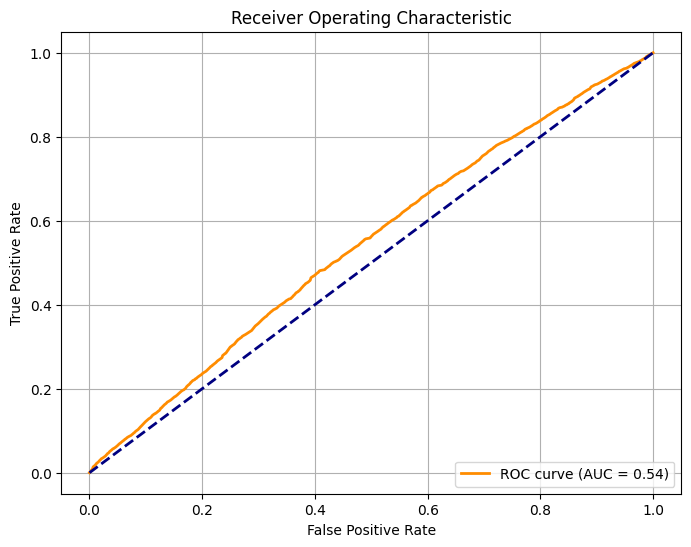

Metrics for crime_category_Public_Order_and_Other_Crime:
roc_auc: 0.5433
accuracy: 0.6936
precision: 0.0000
recall: 0.0000
f1_score: 0.0000
Processing crime_category_Violent_Crime...


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/d

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: crime_category_Violent_Crime
No. Observations: 359004  Method:             REML                        
No. Groups:       227     Scale:              0.1028                      
Min. group size:  58      Log-Likelihood:     inf                         
Max. group size:  15887   Converged:          Yes                         
Mean group size:  1581.5                                                  
---------------------------------------------------------------------------
                            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                   -0.000                                         
median_household_income      0.004     0.002   2.141  0.032   0.000   0.009
gini_index                  -0.001     0.002  -0.704  0.482  -0.004   0.002
poverty_rate                 0.001    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


McFadden's Pseudo-R^2 for crime_category_Violent_Crime: -0.0233


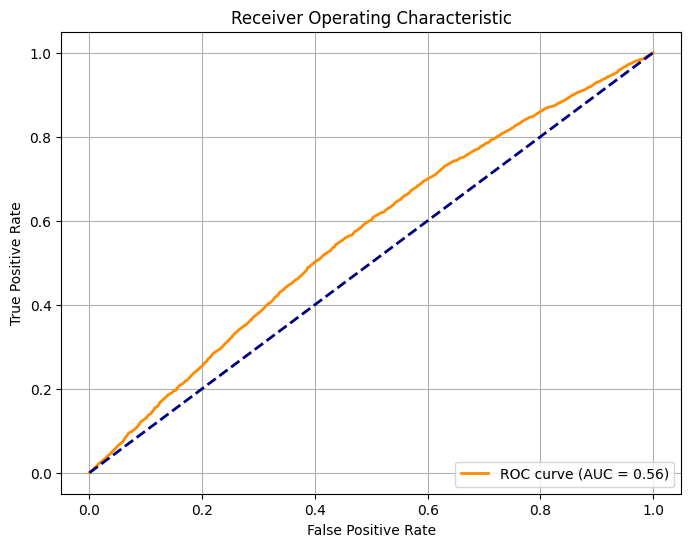

Metrics for crime_category_Violent_Crime:
roc_auc: 0.5643
accuracy: 0.8803
precision: 0.0000
recall: 0.0000
f1_score: 0.0000
Processing crime_category_Property_Crime...


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/d

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: crime_category_Property_Crime
No. Observations: 359004  Method:             REML                         
No. Groups:       227     Scale:              0.2306                       
Min. group size:  58      Log-Likelihood:     inf                          
Max. group size:  15887   Converged:          Yes                          
Mean group size:  1581.5                                                   
----------------------------------------------------------------------------
                             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------------------
Intercept                     0.000                                         
median_household_income       0.026     0.003   8.506  0.000   0.020   0.033
gini_index                    0.014     0.002   5.946  0.000   0.010   0.019
poverty_rate             

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


McFadden's Pseudo-R^2 for crime_category_Property_Crime: -0.6182


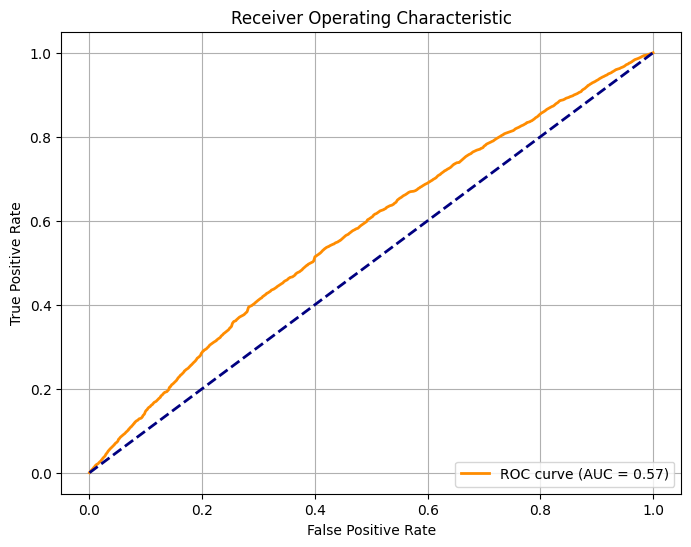

Metrics for crime_category_Property_Crime:
roc_auc: 0.5720
accuracy: 0.4261
precision: 0.0000
recall: 0.0000
f1_score: 0.0000


In [ ]:
crime_categories = [
    "crime_category_Public_Order_and_Other_Crime",
    "crime_category_Violent_Crime",
    "crime_category_Property_Crime"
]

predictors = ['median_household_income', 'gini_index', 'poverty_rate', 'unemployment_rate', 'median_home_value',
              'bachelor_rate', 'public_transit_rate', 'bicycle_rate', 'walking_rate',
              'white_proportion', 'black_proportion', 'asian_proportion', 'hispanic_proportion']
random_effect = 'tract'
results = {}

def calculate_variance_components(model):
    """
    Calculate within-tract and across-tract variance proportions from a mixed-effects model.

    Parameters:
        model: Fitted mixed-effects logistic regression model.

    Returns:
        dict: Dictionary containing within-tract and across-tract variances and proportions.
    """
    # Extract variance components
    random_effect_variance = model.cov_re.iloc[0, 0]  # Random effect variance (tract-level)
    residual_variance = model.scale  # Residual variance (individual-level)

    # Total variance
    total_variance = random_effect_variance + residual_variance

    # Variance proportions
    within_proportion = residual_variance / total_variance
    across_proportion = random_effect_variance / total_variance

    return {
        'random_effect_variance': random_effect_variance,
        'residual_variance': residual_variance,
        'within_proportion': within_proportion,
        'across_proportion': across_proportion
    }

for crime in crime_categories:
    print(f"Processing {crime}...")

    # Filter training data
    filtered_train_data = filter_tracts_with_no_positive_cases(train_data, crime)

    # Train logistic regression model
    model = train_mixed_effects_logistic(filtered_train_data, crime, predictors, 'tract')
    print(model.summary())  # Print model summary for training data

    # Calculate variance components
    variance_components = calculate_variance_components(model)
    print(f"Variance Components for {crime}:")
    print(f" - Random Effect Variance: {variance_components['random_effect_variance']:.4f}")
    print(f" - Residual Variance: {variance_components['residual_variance']:.4f}")
    print(f" - Within-Tract Variance Proportion: {variance_components['within_proportion']:.4f}")
    print(f" - Across-Tract Variance Proportion: {variance_components['across_proportion']:.4f}")

    # Filter test data to exclude tracts without variance
    filtered_test_data = filter_tracts_with_no_positive_cases(test_data, crime)

    # Evaluate model
    metrics = evaluate_model(model, filtered_test_data, crime, predictors)
    results[crime] = metrics

    # Calculate and print McFadden's pseudo-R^2
    pseudo_r2 = calculate_pseudo_r2(model, filtered_test_data, crime, predictors)
    print(f"McFadden's Pseudo-R^2 for {crime}: {pseudo_r2:.4f}")

    # Visualize ROC curve
    plot_roc_curve(filtered_test_data, crime)

    # Print metrics
    print(f"Metrics for {crime}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Given the bad performance of mixed-effects model and no variation across tracts, I instead use logistic models only with tracts controlled for as fixed-effects.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

def train_penalized_logistic_sm(train_data, dependent_var, predictors, group_var, penalty='elasticnet', l1_ratio=0.5, C=1.0):
    """
    Train a penalized logistic regression model with both L1 (LASSO) and L2 (Ridge) penalties
    and print a detailed summary using statsmodels.

    Parameters:
        train_data (DataFrame): Training dataset.
        dependent_var (str): Dependent variable name.
        predictors (list): List of predictor variable names.
        group_var (str): Grouping variable for fixed effects (e.g., 'tract').
        penalty (str): Type of penalty ('elasticnet' for L1 and L2 combination).
        l1_ratio (float): Ratio of L1 penalty in elasticnet (0 = pure Ridge, 1 = pure LASSO).
        C (float): Inverse of regularization strength (smaller values = stronger regularization).

    Returns:
        model: Fitted logistic regression model.
        encoder: OneHotEncoder instance fitted to the group variable.
        full_feature_names: Full list of feature names, including one-hot encoded dummies.
    """
    from sklearn.preprocessing import OneHotEncoder

    # One-hot encode group variable
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    tract_dummies = encoder.fit_transform(train_data[[group_var]])
    tract_df = pd.DataFrame(tract_dummies, columns=encoder.get_feature_names_out([group_var]), index=train_data.index)

    # Combine predictors and group dummies
    X = pd.concat([train_data[predictors], tract_df], axis=1)
    y = train_data[dependent_var]

    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    # Fit penalized logistic regression using sklearn
    logistic_model = LogisticRegression(
        penalty=penalty, solver='saga', l1_ratio=l1_ratio, C=C, max_iter=1000
    )
    logistic_model.fit(X, y)

    # Return the encoder and full feature names
    return logistic_model, encoder, X.columns.tolist()





def evaluate_model(model, encoder, test_data, dependent_var, predictors, group_var, full_feature_names):
    """
    Evaluate the penalized logistic regression model.

    Parameters:
        model: Fitted logistic regression model.
        encoder: OneHotEncoder fitted on group variable.
        test_data (DataFrame): Test dataset.
        dependent_var (str): Dependent variable name.
        predictors (list): List of predictor variable names.
        group_var (str): Grouping variable for fixed effects (e.g., 'tract').
        full_feature_names (list): Full list of feature names from the training set.

    Returns:
        dict: Evaluation metrics including accuracy, precision, recall, F1 score, and ROC AUC.
    """
    # One-hot encode group variable using the same encoder
    tract_dummies_test = encoder.transform(test_data[[group_var]])
    tract_df_test = pd.DataFrame(tract_dummies_test, columns=encoder.get_feature_names_out([group_var]), index=test_data.index)

    # Combine predictors and group dummies
    X_test = pd.concat([test_data[predictors], tract_df_test], axis=1)

    # Ensure all column names are strings
    X_test.columns = X_test.columns.astype(str)

    # Align test data with training feature names
    X_test = X_test.reindex(columns=full_feature_names, fill_value=0)

    y_test = test_data[dependent_var]

    # Make predictions
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_class = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_class),
        'precision': precision_score(y_test, y_pred_class, zero_division=0),
        'recall': recall_score(y_test, y_pred_class, zero_division=0),
        'f1_score': f1_score(y_test, y_pred_class, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_prob)
    }
    return metrics




import statsmodels.api as sm

def summarize_model_sm(train_data, dependent_var, predictors, group_var):
    """
    Generate a summary of the logistic regression model using statsmodels,
    excluding tract-level coefficients.

    Parameters:
        train_data (DataFrame): Training dataset.
        dependent_var (str): Dependent variable name.
        predictors (list): List of predictor variable names.
        group_var (str): Grouping variable for fixed effects (e.g., 'tract').

    Returns:
        DataFrame: Summary of the model including coefficients, standard errors, and p-values.
    """
    # Prepare data for statsmodels
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    tract_dummies = encoder.fit_transform(train_data[[group_var]])
    tract_df = pd.DataFrame(tract_dummies, columns=encoder.get_feature_names_out(), index=train_data.index)
    X = pd.concat([train_data[predictors], tract_df], axis=1)
    y = train_data[dependent_var]

    # Ensure indices are aligned
    X = X.loc[y.index]  # Align indices explicitly

    # Fit logistic regression using statsmodels
    X_sm = sm.add_constant(X)  # Add intercept
    model_sm = sm.Logit(y, X_sm).fit(disp=False)  # Suppress output

    # Extract summary, excluding tract-related coefficients
    summary_df = model_sm.summary2().tables[1].reset_index()
    summary_df = summary_df[~summary_df["index"].str.startswith("tract_")]

    return summary_df, encoder






def calculate_out_of_sample_r2(model, encoder, test_data, dependent_var, predictors, group_var):
    """
    Calculate out-of-sample R² for the logistic regression model.

    Parameters:
        model: Fitted logistic regression model.
        encoder: OneHotEncoder fitted on group variable.
        test_data (DataFrame): Test dataset.
        dependent_var (str): Dependent variable name.
        predictors (list): List of predictor variable names.
        group_var (str): Grouping variable for fixed effects (e.g., 'tract').

    Returns:
        float: Out-of-sample R².
    """
    # Prepare test data
    tract_dummies_test = encoder.transform(test_data[[group_var]])
    tract_dummies_df = pd.DataFrame(tract_dummies_test, columns=encoder.get_feature_names_out([group_var]), index=test_data.index)
    X_test = pd.concat(
        [test_data[predictors].reset_index(drop=True), pd.DataFrame(tract_dummies_test)],
        axis=1
    )
    X_test = X_test.reindex(columns=full_feature_names, fill_value=0)
    y_test = test_data[dependent_var]
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_test_mean = y_test.mean()

    # Deviance-based R²
    null_deviance = -2 * sum(y_test * np.log(y_test_mean) + (1 - y_test) * np.log(1 - y_test_mean))
    residual_deviance = -2 * sum(y_test * np.log(y_pred_prob) + (1 - y_test) * np.log(1 - y_pred_prob))
    oos_r2 = 1 - (residual_deviance / null_deviance)
    return oos_r2


def plot_auc_roc_curve(y_test, y_pred_prob, crime):
    """
    Plot the AUC-ROC curve.

    Parameters:
        y_test (Series): True labels.
        y_pred_prob (array): Predicted probabilities.
        crime (str): Name of the crime category for the plot title.
    """
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {crime}')
    plt.legend(loc='lower right')
    plt.show()


# Main Workflow
crime_categories = [
    "crime_category_Public_Order_and_Other_Crime",
    "crime_category_Violent_Crime",
    "crime_category_Property_Crime"
]

predictors = ['median_household_income', 'gini_index', 'poverty_rate', 'unemployment_rate', 'median_home_value',
              'bachelor_rate', 'public_transit_rate', 'bicycle_rate', 'walking_rate',
              'white_proportion', 'black_proportion', 'asian_proportion', 'hispanic_proportion']
group_var = 'tract'
results = {}

train_data[group_var] = train_data[group_var].astype("category")
test_data[group_var] = test_data[group_var].astype("category")


for crime in crime_categories:
    print(f"Processing {crime}...")

    # Filter training data
    filtered_train_data = filter_tracts_with_no_positive_cases(train_data, crime)

    # Train penalized logistic regression model
    model, encoder, full_feature_names = train_penalized_logistic_sm(
        filtered_train_data, crime, predictors, group_var, penalty='elasticnet', l1_ratio=0.5, C=1.0
    )

    # Model summary using statsmodels
    summary, encoder = summarize_model_sm(filtered_train_data, crime, predictors, group_var)
    print(f"Model Summary for {crime}:\n", summary)

    # Filter test data
    filtered_test_data = filter_tracts_with_no_positive_cases(test_data, crime)

    # Evaluate model
    metrics = evaluate_model(model, encoder, filtered_test_data, crime, predictors, group_var, full_feature_names)
    results[crime] = metrics

    # Calculate out-of-sample R²
    oos_r2 = calculate_out_of_sample_r2(model, encoder, filtered_test_data, crime, predictors, group_var)
    print(f"Out-of-Sample R² for {crime}: {oos_r2:.4f}")

    # Print metrics
    print(f"Metrics for {crime}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Processing crime_category_Public_Order_and_Other_Crime...


<ipython-input-12-bda1ac37dc9d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_tracts = data.groupby('tract')[dependent_var].sum()


Model Summary for crime_category_Public_Order_and_Other_Crime:
                       index     Coef.  Std.Err.          z         P>|z|  \
0                     const -2.041584  0.052445 -38.928464  0.000000e+00   
1   median_household_income -0.107101  0.014534  -7.369046  1.718529e-13   
2                gini_index -0.041173  0.011147  -3.693599  2.211024e-04   
3              poverty_rate  0.055802  0.012668   4.405098  1.057362e-05   
4         unemployment_rate  0.013132  0.007382   1.779020  7.523646e-02   
5         median_home_value -0.078563  0.010784  -7.285018  3.216265e-13   
6             bachelor_rate -0.058739  0.015009  -3.913512  9.096332e-05   
7       public_transit_rate -0.012626  0.010302  -1.225594  2.203514e-01   
8              bicycle_rate  0.029512  0.020805   1.418499  1.560452e-01   
9              walking_rate -0.013248  0.010391  -1.274875  2.023537e-01   
10         white_proportion -0.001814  0.027932  -0.064958  9.482075e-01   
11         black_proport

<ipython-input-12-bda1ac37dc9d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_tracts = data.groupby('tract')[dependent_var].sum()


Out-of-Sample R² for crime_category_Public_Order_and_Other_Crime: -0.0835
Metrics for crime_category_Public_Order_and_Other_Crime:
accuracy: 0.6945
precision: 0.5627
recall: 0.0326
f1_score: 0.0617
roc_auc: 0.6023
Processing crime_category_Violent_Crime...


<ipython-input-12-bda1ac37dc9d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_tracts = data.groupby('tract')[dependent_var].sum()


Model Summary for crime_category_Violent_Crime:
                       index     Coef.  Std.Err.          z     P>|z|  \
0                     const -3.049924  0.078509 -38.848319  0.000000   
1   median_household_income  0.040774  0.021379   1.907181  0.056497   
2                gini_index -0.025819  0.015970  -1.616703  0.105942   
3              poverty_rate  0.026402  0.017228   1.532555  0.125386   
4         unemployment_rate -0.001286  0.010087  -0.127460  0.898576   
5         median_home_value -0.037091  0.015388  -2.410457  0.015933   
6             bachelor_rate  0.016296  0.021496   0.758089  0.448398   
7       public_transit_rate -0.043986  0.014507  -3.031978  0.002430   
8              bicycle_rate  0.024025  0.030843   0.778946  0.436012   
9              walking_rate -0.062213  0.014324  -4.343276  0.000014   
10         white_proportion -0.072990  0.038106  -1.915437  0.055437   
11         black_proportion -0.026535  0.029774  -0.891202  0.372821   
12         asia

<ipython-input-12-bda1ac37dc9d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_tracts = data.groupby('tract')[dependent_var].sum()


Out-of-Sample R² for crime_category_Violent_Crime: -0.0243
Metrics for crime_category_Violent_Crime:
accuracy: 0.8798
precision: 0.0000
recall: 0.0000
f1_score: 0.0000
roc_auc: 0.6286
Processing crime_category_Property_Crime...


<ipython-input-12-bda1ac37dc9d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_tracts = data.groupby('tract')[dependent_var].sum()


Model Summary for crime_category_Property_Crime:
                       index     Coef.  Std.Err.          z          P>|z|  \
0                     const  1.647685  0.047199  34.909403  5.353020e-267   
1   median_household_income  0.083535  0.013646   6.121664   9.260306e-10   
2                gini_index  0.048766  0.010532   4.630204   3.653060e-06   
3              poverty_rate -0.062364  0.011944  -5.221191   1.777756e-07   
4         unemployment_rate -0.011691  0.006984  -1.673950   9.414048e-02   
5         median_home_value  0.082207  0.010014   8.209499   2.221137e-16   
6             bachelor_rate  0.044298  0.013946   3.176324   1.491540e-03   
7       public_transit_rate  0.031567  0.009716   3.249013   1.158061e-03   
8              bicycle_rate -0.034049  0.019427  -1.752648   7.966249e-02   
9              walking_rate  0.038397  0.009816   3.911602   9.168581e-05   
10         white_proportion  0.036834  0.026401   1.395178   1.629620e-01   
11         black_proportio

<ipython-input-12-bda1ac37dc9d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_tracts = data.groupby('tract')[dependent_var].sum()


Out-of-Sample R² for crime_category_Property_Crime: -0.1341
Metrics for crime_category_Property_Crime:
accuracy: 0.6101
precision: 0.6206
recall: 0.8191
f1_score: 0.7062
roc_auc: 0.6328


In [ ]:
print("Unique tracts in train_data:", train_data[group_var].unique())
print("Unique tracts in test_data:", test_data[group_var].unique())

# Check for tracts in test_data that are not in train_data
missing_in_train = set(test_data[group_var].unique()) - set(train_data[group_var].unique())
print("Tracts in test_data but not in train_data:", missing_in_train)

# Check for tracts in train_data that are not in test_data
missing_in_test = set(train_data[group_var].unique()) - set(test_data[group_var].unique())
print("Tracts in train_data but not in test_data:", missing_in_test)


NameError: name 'group_var' is not defined

In [ ]:
# After encoding
train_dummies = encoder.transform(train_data[[group_var]])
test_dummies = encoder.transform(test_data[[group_var]])

print("Train dummy variable shape:", train_dummies.shape)
print("Test dummy variable shape:", test_dummies.shape)

# Check if column names align
train_columns = encoder.get_feature_names_out([group_var])
print("Columns in train dummies:", train_columns)

test_columns = encoder.get_feature_names_out([group_var])
print("Columns in test dummies:", test_columns)

# Identify mismatched columns
train_set = set(train_columns)
test_set = set(test_columns)
print("Columns in train but not in test:", train_set - test_set)
print("Columns in test but not in train:", test_set - train_set)


Train dummy variable shape: (359004, 226)
Test dummy variable shape: (153860, 226)
Columns in train dummies: ['tract_1' 'tract_2' 'tract_3' 'tract_4' 'tract_5' 'tract_6' 'tract_7'
 'tract_8' 'tract_9' 'tract_10' 'tract_11' 'tract_12' 'tract_13'
 'tract_14' 'tract_15' 'tract_16' 'tract_17' 'tract_18' 'tract_19'
 'tract_20' 'tract_21' 'tract_22' 'tract_23' 'tract_24' 'tract_25'
 'tract_26' 'tract_27' 'tract_28' 'tract_29' 'tract_30' 'tract_31'
 'tract_32' 'tract_33' 'tract_34' 'tract_35' 'tract_36' 'tract_37'
 'tract_38' 'tract_39' 'tract_40' 'tract_41' 'tract_42' 'tract_43'
 'tract_44' 'tract_45' 'tract_46' 'tract_47' 'tract_48' 'tract_49'
 'tract_50' 'tract_51' 'tract_52' 'tract_53' 'tract_54' 'tract_55'
 'tract_56' 'tract_57' 'tract_58' 'tract_59' 'tract_60' 'tract_61'
 'tract_62' 'tract_63' 'tract_64' 'tract_65' 'tract_66' 'tract_67'
 'tract_68' 'tract_69' 'tract_70' 'tract_71' 'tract_72' 'tract_73'
 'tract_74' 'tract_75' 'tract_76' 'tract_77' 'tract_78' 'tract_79'
 'tract_80' 'tract

In [ ]:
# Aggregate data by tract*year
panel_train_data = train_data.groupby(['tract', 'year']).agg(
    crime_category_Public_Order_and_Other_Crime=('crime_category_Public_Order_and_Other_Crime', 'sum'),
    crime_category_Violent_Crime=('crime_category_Violent_Crime', 'sum'),
    crime_category_Property_Crime=('crime_category_Property_Crime', 'sum'),
    median_household_income=('median_household_income', 'mean'),
    gini_index=('gini_index', 'mean'),
    poverty_rate=('poverty_rate', 'mean'),
    unemployment_rate=('unemployment_rate', 'mean'),
    median_home_value=('median_home_value', 'mean'),
    bachelor_rate=('bachelor_rate', 'mean'),
    public_transit_rate=('public_transit_rate', 'mean'),
    bicycle_rate=('bicycle_rate', 'mean'),
    walking_rate=('walking_rate', 'mean'),
    white_proportion=('white_proportion', 'mean'),
    black_proportion=('black_proportion', 'mean'),
    asian_proportion=('asian_proportion', 'mean'),
    hispanic_proportion=('hispanic_proportion', 'mean')
).reset_index()

# Aggregate data by tract*year
panel_test_data = test_data.groupby(['tract', 'year']).agg(
    crime_category_Public_Order_and_Other_Crime=('crime_category_Public_Order_and_Other_Crime', 'sum'),
    crime_category_Violent_Crime=('crime_category_Violent_Crime', 'sum'),
    crime_category_Property_Crime=('crime_category_Property_Crime', 'sum'),
    median_household_income=('median_household_income', 'mean'),
    gini_index=('gini_index', 'mean'),
    poverty_rate=('poverty_rate', 'mean'),
    unemployment_rate=('unemployment_rate', 'mean'),
    median_home_value=('median_home_value', 'mean'),
    bachelor_rate=('bachelor_rate', 'mean'),
    public_transit_rate=('public_transit_rate', 'mean'),
    bicycle_rate=('bicycle_rate', 'mean'),
    walking_rate=('walking_rate', 'mean'),
    white_proportion=('white_proportion', 'mean'),
    black_proportion=('black_proportion', 'mean'),
    asian_proportion=('asian_proportion', 'mean'),
    hispanic_proportion=('hispanic_proportion', 'mean')
).reset_index()

# Identify tracts with NaN values in panel_train_data
tracts_with_nans_train = panel_train_data.groupby('tract').apply(lambda group: group.isna().any().any())
tracts_to_exclude_train = tracts_with_nans_train[tracts_with_nans_train].index

# Identify tracts with NaN values in panel_test_data
tracts_with_nans_test = panel_test_data.groupby('tract').apply(lambda group: group.isna().any().any())
tracts_to_exclude_test = tracts_with_nans_test[tracts_with_nans_test].index

# Filter out tracts with NaN values in panel_train_data
filtered_panel_train_data = panel_train_data[~panel_train_data['tract'].isin(tracts_to_exclude_train)]

# Filter out tracts with NaN values in panel_test_data
filtered_panel_test_data = panel_test_data[~panel_test_data['tract'].isin(tracts_to_exclude_test)]

filtered_panel_train_data.head(20)

<ipython-input-20-d40328da850b>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tracts_with_nans_train = panel_train_data.groupby('tract').apply(lambda group: group.isna().any().any())
<ipython-input-20-d40328da850b>:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tracts_with_nans_test = panel_test_data.groupby('tract').apply(lambda group: group.isna().any().any())


,tract,year,crime_category_Public_Order_and_Other_Crime,crime_category_Violent_Crime,crime_category_Property_Crime,median_household_income,gini_index,poverty_rate,unemployment_rate,median_home_value,bachelor_rate,public_transit_rate,bicycle_rate,walking_rate,white_proportion,black_proportion,asian_proportion,hispanic_proportion
0,0,2020.0,256.0,94.0,1960.0,-0.952849,0.448282,0.084128,1.000775,2.103514,0.132285,0.276965,0.898058,0.903218,-0.039033,-0.650775,0.914015,-0.918408
1,0,2021.0,244.0,88.0,1928.0,-0.852540,0.647861,0.085092,0.389269,0.716343,0.906667,-0.537255,-0.105059,-0.154118,-0.544019,-0.228481,0.972023,-0.741013
2,0,2022.0,216.0,90.0,1659.0,-0.749224,0.847440,0.331128,1.001309,1.015927,1.612919,-0.924644,-0.425602,-0.503777,-0.536931,0.070467,0.634867,-0.315526
3,1,2020.0,72.0,18.0,341.0,0.246171,0.483979,-1.103654,-1.525995,1.214321,0.610438,0.019653,0.312512,-0.498324,1.917170,-0.295679,-1.311312,-1.224119
4,1,2021.0,69.0,9.0,318.0,0.770565,0.169195,-0.803939,-0.868961,1.338086,0.710057,-0.326248,-0.022972,-0.531981,1.556170,0.182693,-1.392734,-0.852319
5,1,2022.0,92.0,16.0,387.0,0.525654,0.297380,-0.918946,-0.842525,1.610579,1.063272,-1.124216,0.199027,-0.527071,1.322860,0.117694,-1.372569,-0.463805
6,2,2020.0,176.0,51.0,1001.0,1.484934,0.618654,-1.436625,-0.552366,-0.370445,1.665850,-0.032125,0.564620,0.687210,1.496011,-0.298321,-1.028918,-1.377206
7,2,2021.0,139.0,40.0,1036.0,1.428998,0.498582,-0.827464,-0.198029,-0.361149,1.812652,0.425639,0.230022,0.790707,1.554772,-0.422938,-1.103717,-1.376995
8,2,2022.0,113.0,52.0,812.0,1.754677,0.582957,-0.829129,-0.097237,0.551678,1.621551,0.138566,0.662035,0.675038,0.905912,-0.386279,-0.767102,-1.092369
9,3,2017.0,91.0,13.0,186.0,-0.059907,1.081094,-0.206693,-0.654378,0.244392,0.483370,-0.063390,0.740529,-0.332417,0.824034,-0.746846,0.105978,-0.592061


Processing crime_category_Public_Order_and_Other_Crime...
                              Generalized Linear Model Regression Results                              
Dep. Variable:     crime_category_Public_Order_and_Other_Crime   No. Observations:                 1082
Model:                                                     GLM   Df Residuals:                     1068
Model Family:                                          Poisson   Df Model:                           13
Link Function:                                             Log   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -31970.
Date:                                         Mon, 09 Dec 2024   Deviance:                       57321.
Time:                                                 21:13:59   Pearson chi2:                 7.33e+04
No. Iterations:                                              5   Pseudo R-squ. (CS):              1.000
Covari

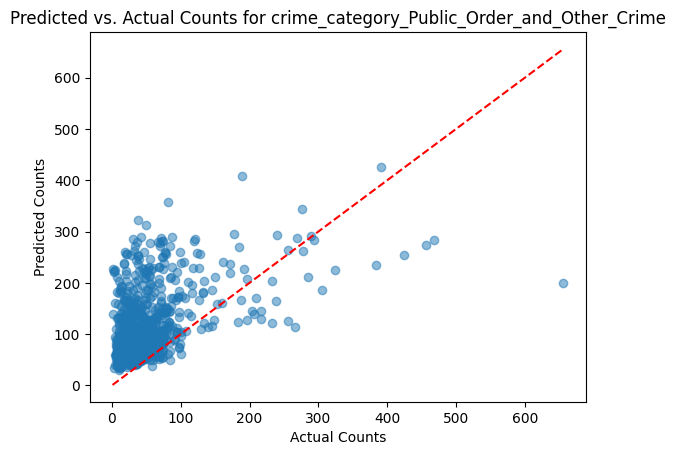

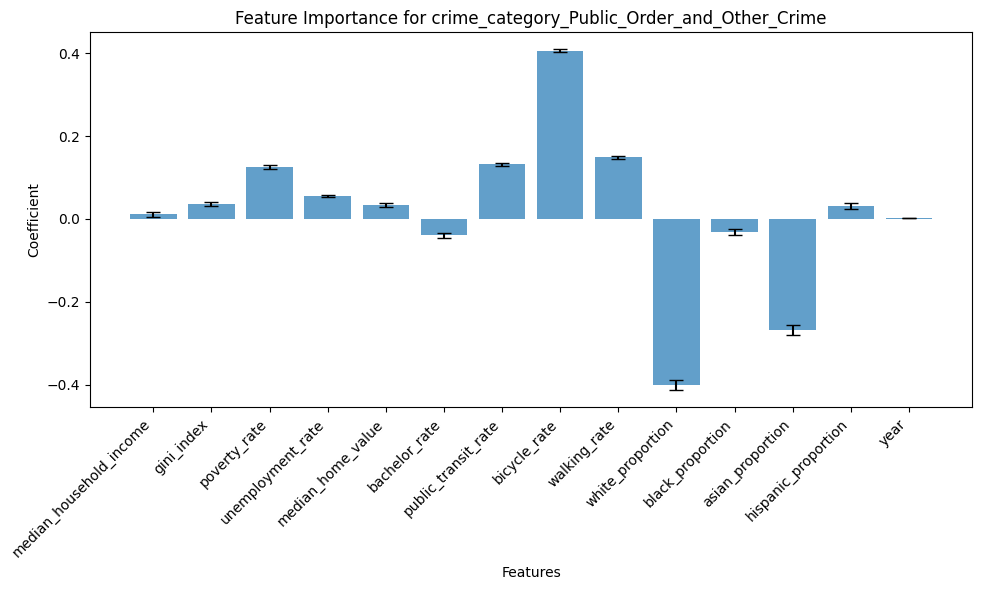

Processing crime_category_Violent_Crime...
                      Generalized Linear Model Regression Results                       
Dep. Variable:     crime_category_Violent_Crime   No. Observations:                 1082
Model:                                      GLM   Df Residuals:                     1068
Model Family:                           Poisson   Df Model:                           13
Link Function:                              Log   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:                -14501.
Date:                          Mon, 09 Dec 2024   Deviance:                       23556.
Time:                                  21:14:00   Pearson chi2:                 2.93e+04
No. Iterations:                               5   Pseudo R-squ. (CS):              1.000
Covariance Type:                      nonrobust                                         
                              coef    std err          z      P>|z|

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


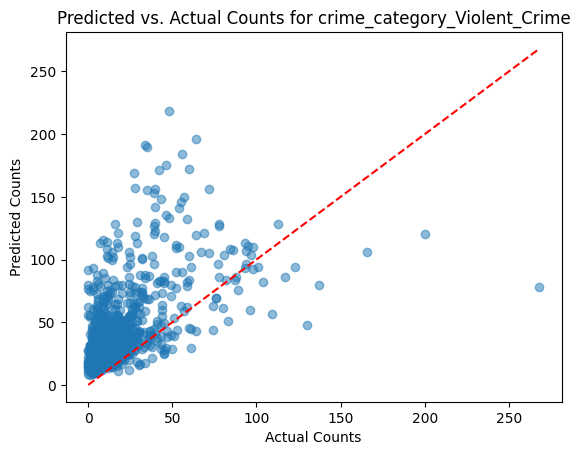

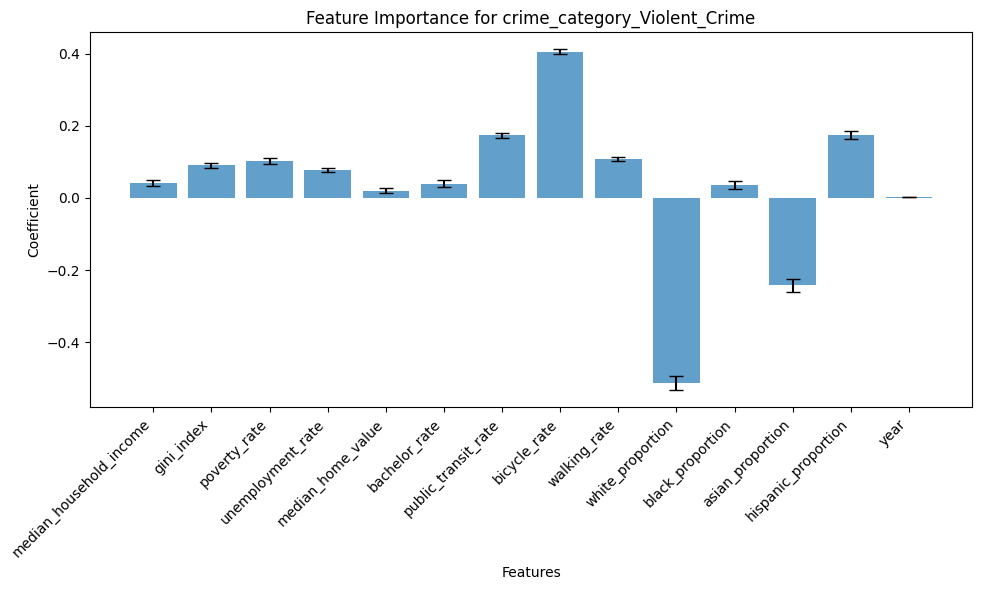

Processing crime_category_Property_Crime...
                       Generalized Linear Model Regression Results                       
Dep. Variable:     crime_category_Property_Crime   No. Observations:                 1082
Model:                                       GLM   Df Residuals:                     1068
Model Family:                            Poisson   Df Model:                           13
Link Function:                               Log   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -56945.
Date:                           Mon, 09 Dec 2024   Deviance:                   1.0654e+05
Time:                                   21:14:00   Pearson chi2:                 1.41e+05
No. Iterations:                                5   Pseudo R-squ. (CS):              1.000
Covariance Type:                       nonrobust                                         
                              coef    std err          z

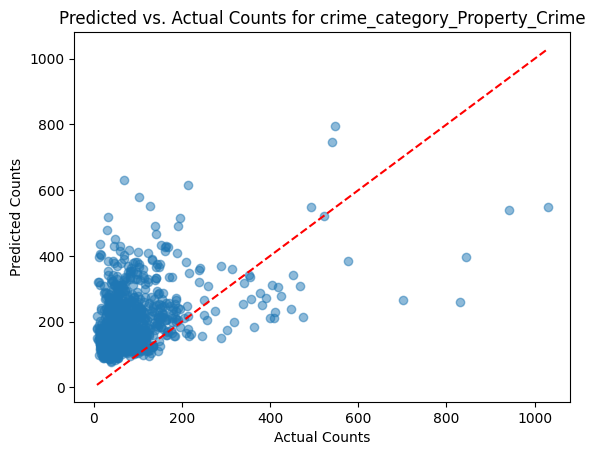

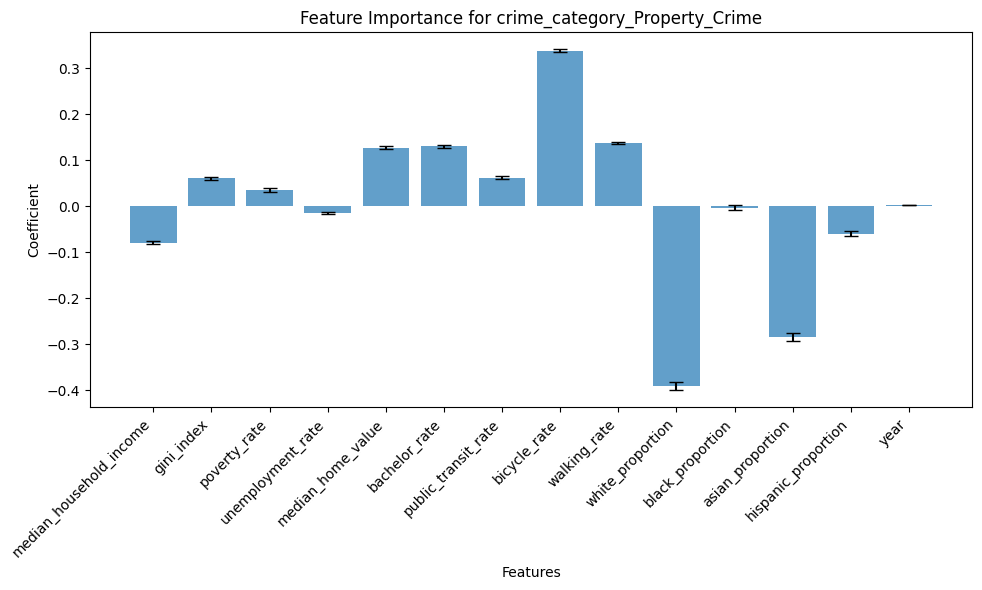

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import GLM, families
from sklearn.metrics import mean_squared_error, mean_absolute_error


crime_categories = [
    "crime_category_Public_Order_and_Other_Crime",
    "crime_category_Violent_Crime",
    "crime_category_Property_Crime"
]

predictors = ['median_household_income', 'gini_index', 'poverty_rate', 'unemployment_rate', 'median_home_value',
              'bachelor_rate', 'public_transit_rate', 'bicycle_rate', 'walking_rate',
              'white_proportion', 'black_proportion', 'asian_proportion', 'hispanic_proportion']

def evaluate_count_model_poisson(model, test_data, dependent_var, predictors):
    """
    Evaluate the Poisson-based GLM model.

    Parameters:
        model: Fitted GLM model.
        test_data: Test dataset.
        dependent_var: Dependent variable name.
        predictors: Predictor variable names.

    Returns:
        dict: Evaluation metrics including RMSE, MAE, and Deviance.
        Series: Actual and predicted values for plotting.
    """
    # Extract predictors and actual counts
    X_test = test_data[predictors + ['year']]
    y_test = test_data[dependent_var]

    # Predict counts
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    deviance = np.sum(2 * (y_test * np.log(y_test / y_pred) - (y_test - y_pred)))

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'Deviance': deviance
    }

    return metrics, y_test, y_pred

def plot_feature_importance(model, predictors, crime_category):
    """
    Plot feature importance with error bars for the Poisson GLM model.

    Parameters:
        model: Fitted GLM model.
        predictors: List of predictors.
        crime_category: Crime category for the plot title.
    """
    # Extract coefficients and standard errors
    coef = model.params
    std_err = model.bse

    # Select only predictors (exclude intercept)
    predictors_with_year = predictors + ['year']
    coef = coef[predictors_with_year]
    std_err = std_err[predictors_with_year]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(predictors_with_year, coef, yerr=std_err, alpha=0.7, capsize=5)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Features")
    plt.ylabel("Coefficient")
    plt.title(f"Feature Importance for {crime_category}")
    plt.tight_layout()
    plt.show()

# Iterate over crime categories
for crime in crime_categories:
    print(f"Processing {crime}...")

    # Prepare dependent and independent variables
    y_train = filtered_panel_train_data[crime]
    X_train = filtered_panel_train_data[predictors + ['year']]

    # Fit Poisson GLM model
    poisson_model = GLM(
        endog=y_train,
        exog=X_train,
        family=families.Poisson()
    ).fit()

    print(poisson_model.summary())

    # Evaluate on test data
    metrics, y_test, y_pred = evaluate_count_model_poisson(
        poisson_model, filtered_panel_test_data, crime, predictors
    )
    results[crime] = metrics

    # Print metrics
    print(f"Metrics for {crime}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot predicted vs. actual counts
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel("Actual Counts")
    plt.ylabel("Predicted Counts")
    plt.title(f"Predicted vs. Actual Counts for {crime}")
    plt.show()

    # Plot feature importance with error bars
    plot_feature_importance(poisson_model, predictors, crime)


Processing crime_category_Public_Order_and_Other_Crime...
                              Generalized Linear Model Regression Results                              
Dep. Variable:     crime_category_Public_Order_and_Other_Crime   No. Observations:                 1082
Model:                                                     GLM   Df Residuals:                     1068
Model Family:                                 NegativeBinomial   Df Model:                           13
Link Function:                                             log   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -5954.0
Date:                                         Mon, 09 Dec 2024   Deviance:                       468.43
Time:                                                 21:14:07   Pearson chi2:                     576.
No. Iterations:                                              9   Pseudo R-squ. (CS):             0.2330
Covari

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


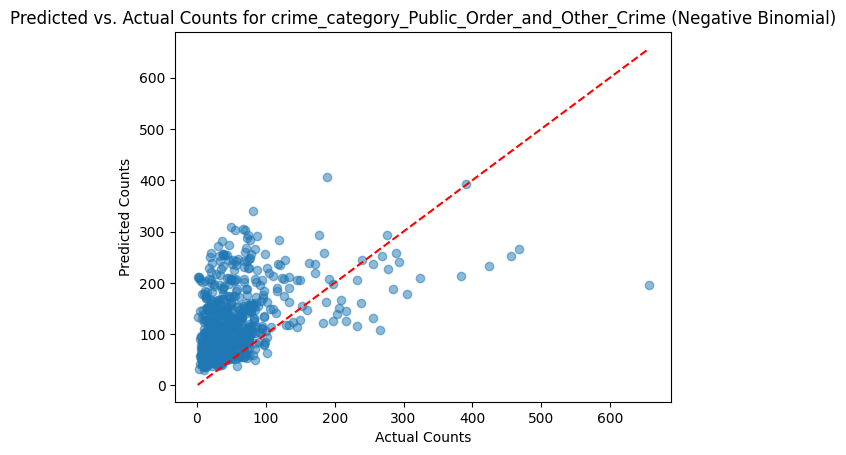

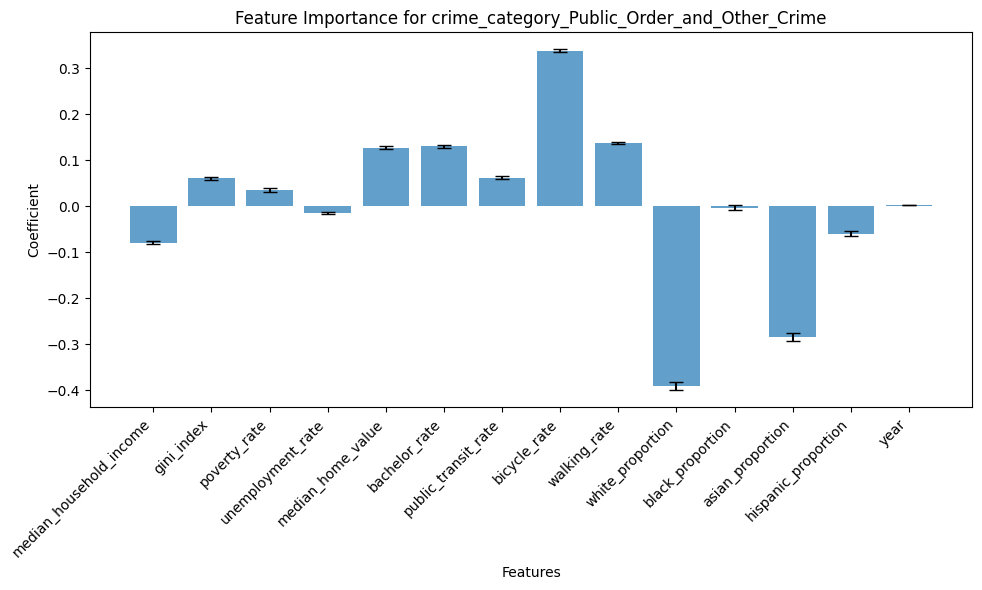

Processing crime_category_Violent_Crime...
                      Generalized Linear Model Regression Results                       
Dep. Variable:     crime_category_Violent_Crime   No. Observations:                 1082
Model:                                      GLM   Df Residuals:                     1068
Model Family:                  NegativeBinomial   Df Model:                           13
Link Function:                              log   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:                -4854.8
Date:                          Mon, 09 Dec 2024   Deviance:                       582.16
Time:                                  21:14:08   Pearson chi2:                     655.
No. Iterations:                              10   Pseudo R-squ. (CS):             0.3508
Covariance Type:                      nonrobust                                         
                              coef    std err          z      P>|z|

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


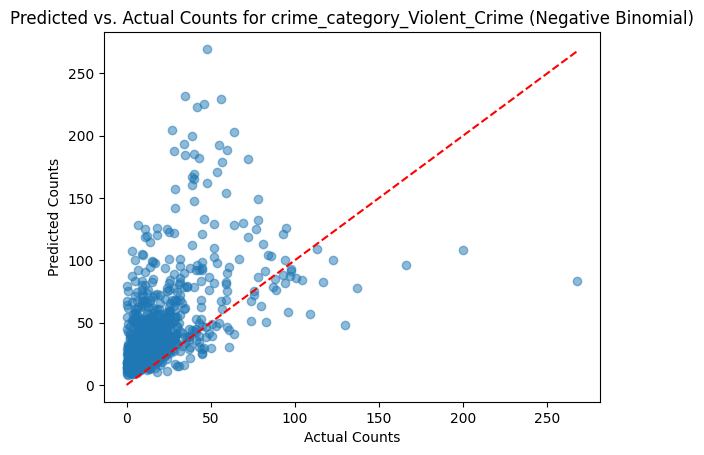

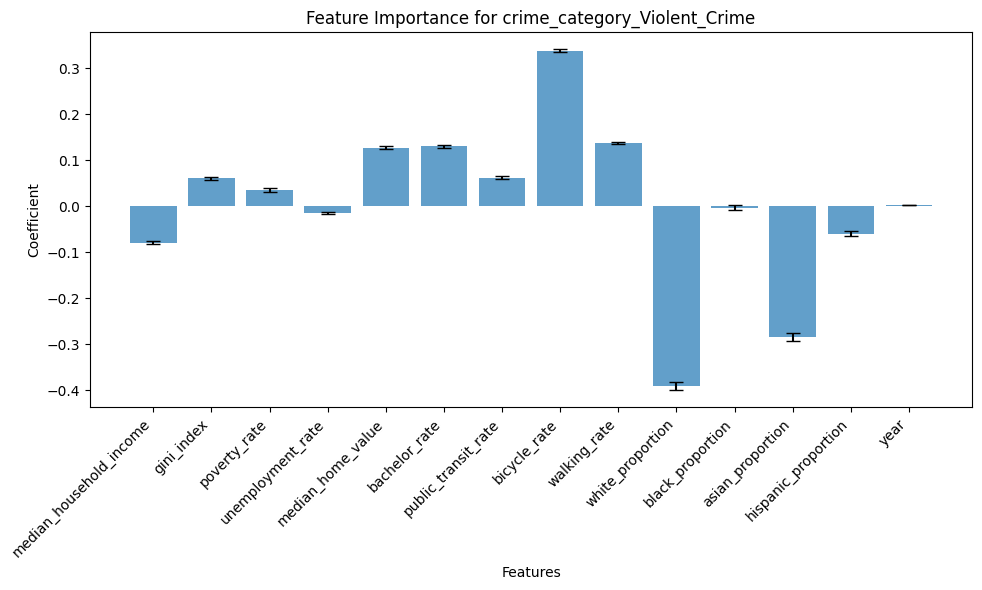

Processing crime_category_Property_Crime...
                       Generalized Linear Model Regression Results                       
Dep. Variable:     crime_category_Property_Crime   No. Observations:                 1082
Model:                                       GLM   Df Residuals:                     1068
Model Family:                   NegativeBinomial   Df Model:                           13
Link Function:                               log   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -6675.3
Date:                           Mon, 09 Dec 2024   Deviance:                       465.67
Time:                                   21:14:08   Pearson chi2:                     629.
No. Iterations:                               11   Pseudo R-squ. (CS):             0.1545
Covariance Type:                       nonrobust                                         
                              coef    std err          z

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


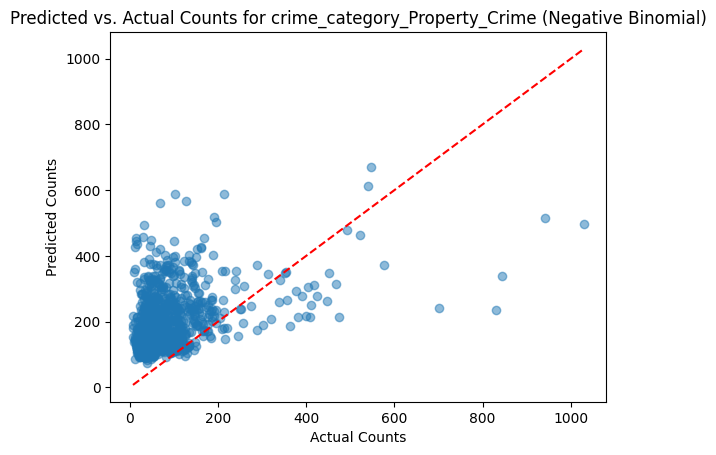

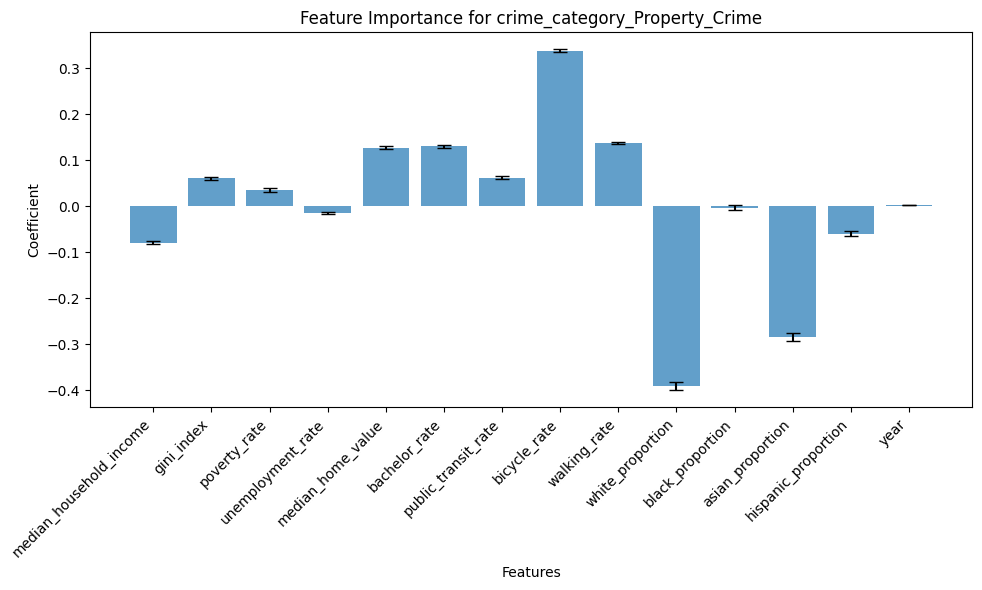

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.api import GLM, families
from statsmodels.genmod.families import links
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

def evaluate_count_model_nb(model, test_data, dependent_var, predictors):
    """
    Evaluate the Negative Binomial-based GLM model.

    Parameters:
        model: Fitted GLM model.
        test_data: Test dataset.
        dependent_var: Dependent variable name.
        predictors: Predictor variable names.

    Returns:
        dict: Evaluation metrics including RMSE, R², MAE, and Deviance.
        Series: Actual and predicted values for plotting.
    """
    # Extract predictors and actual counts
    X_test = test_data[predictors + ['year']]
    y_test = test_data[dependent_var]

    # Predict counts
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    deviance = np.sum(2 * (y_test * np.log(y_test / y_pred) - (y_test - y_pred)))

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'Deviance': deviance
    }

    return metrics, y_test, y_pred

def plot_feature_importance(model, predictors, crime_category):
    """
    Plot feature importance with error bars for the Poisson GLM model.

    Parameters:
        model: Fitted GLM model.
        predictors: List of predictors.
        crime_category: Crime category for the plot title.
    """
    # Extract coefficients and standard errors
    coef = model.params
    std_err = model.bse

    # Select only predictors (exclude intercept)
    predictors_with_year = predictors + ['year']
    coef = coef[predictors_with_year]
    std_err = std_err[predictors_with_year]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(predictors_with_year, coef, yerr=std_err, alpha=0.7, capsize=5)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Features")
    plt.ylabel("Coefficient")
    plt.title(f"Feature Importance for {crime_category}")
    plt.tight_layout()
    plt.show()

# Iterate over crime categories
for crime in crime_categories:
    print(f"Processing {crime}...")

    # Prepare dependent and independent variables
    y_train = filtered_panel_train_data[crime]
    X_train = filtered_panel_train_data[predictors + ['year']]

    # Fit Negative Binomial GLM model
    nb_model = GLM(
        endog=y_train,
        exog=X_train,
        family=families.NegativeBinomial(link=links.log())
    ).fit()

    print(nb_model.summary())

    # Evaluate on test data
    metrics, y_test, y_pred = evaluate_count_model_nb(
        nb_model, filtered_panel_test_data, crime, predictors
    )
    results[crime] = metrics

    # Print metrics
    print(f"Metrics for {crime}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot predicted vs. actual counts
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel("Actual Counts")
    plt.ylabel("Predicted Counts")
    plt.title(f"Predicted vs. Actual Counts for {crime} (Negative Binomial)")
    plt.show()

    # Plot feature importance with error bars
    plot_feature_importance(poisson_model, predictors, crime)